In [5]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from tools import *

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread 

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
from matplotlib import animation, rc
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tools
import elephant
import quantities as pq
from neo.core import SpikeTrain
import viziphant
from pyvis.network import Network
import networkx as nx
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio
from hmmlearn import hmm
import numba 
from multiprocessing import Pool
import pandas as pd 

In [6]:
dure_simu = 38000
begining_presentation = 0
duree_pattern = 0.1
time_step = 0.1
auryn_tstep = 0.0001
spls = dure_simu/time_step

In [7]:
deb = 100
dur = 2
beg = int(deb//time_step)
end = beg+int(dur//time_step)


In [8]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("/mnt/data1/data_paul/new_formula_plas_inh/sim_pat1_oscillating") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096

In [9]:
#datadir_sigal = os.path.expanduser("~/data/sim_network/sim_10Hz_cons_4h_1pat_mrco_5_demonstration") # Set this to your data path
datadir_sigal = datadir

In [10]:
all_times = np.genfromtxt(datadir_sigal+'/pattern_times', delimiter=' ')
nb_pattern = len(set(all_times[:,1]))
signals = np.zeros((nb_pattern,int(dure_simu//time_step)+1))
signals_times = [[] for i in range(nb_pattern)]
for time,kind in all_times:
    signals_times[int(kind)].append(time)
    signals[int(kind),int((time)//time_step):int((time*auryn_tstep+(duree_pattern))//time_step)]=1
signals_times = np.array(signals_times)


In [11]:

spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(0,num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


In [1719]:
rateE  = np.mean([pd.read_csv("%s/%s.%i.e.prate"%(datadir,prefix,2),delimiter=' ').values for i in range(num_mpi_ranks)],axis=0)

In [1720]:
time_axis = np.linspace(0,dure_simu,int(dure_simu//time_step))
rateE= rateE[:,1]


In [1721]:
len(rateE)

37999999

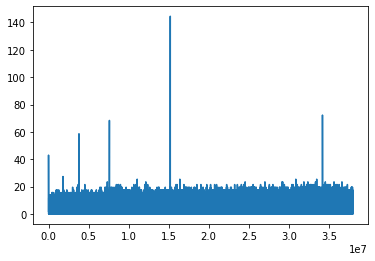

In [1722]:
plt.plot(rateE)

In [1723]:
win = signal.windows.hann(10)
fig = go.Figure(data=go.Scatter(x=time_axis[-100000:], y=(np.convolve(rateE,win,'same')/ sum(win))[-100000:]))
fig.show()

In [1724]:
def plot_profile(begin,end,title,nb_sample,nb_sample_ext,alpha = 1,signal = 0,more_than = 1000):

    tm_rast = begin
    time_range_rast = end
    beg_2 = int(tm_rast//time_step)
    end_2 = beg_2+int(time_range_rast//time_step)
    
    spikes_rast = np.array(sfo.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    ListTrains = [[] for _ in range(nb_neurons)] 
    for s in spikes_rast:
        ListTrains[int(s[1])].append(s[0])

    spikes_rast  = np.array([li for li in spikes_rast if len(ListTrains[int(li[1])])<more_than])
    np.random.seed(0)
    sample = np.random.choice(list(range(nb_neurons)),nb_sample)
    spikes_rast_sample = np.array([i for i in spikes_rast if i[1] in sample])

    spikes_rast_ext = np.array(sfo_ext.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    sample_ext = np.random.choice(list(range(nb_neurons)),nb_sample_ext)
    spikes_rast_sample_ext =np.array([i for i in spikes_rast_ext if i[1] in sample_ext])
    
    new_indexes = dict(zip(list(set(spikes_rast_sample[:,1])),list(range(nb_sample))))
    
    new_indexes_ext = dict(zip(list(set(spikes_rast_sample_ext[:,1])),list(range(nb_sample_ext))))
    
    colors = in_pattern(spikes_rast_sample_ext,duree_pattern, signals_times[0])
    colors = ["r" if i ==1 else "b" for i in colors]
    
    fig, axs = plt.subplots(3,figsize=(8,10),sharex=True,gridspec_kw={'height_ratios': [2,2, 1]})
    fig.suptitle(title,y = 0.92,fontsize = 15)
    
    axs[0].scatter(spikes_rast_sample_ext[:,0], 
                   [new_indexes_ext[i] for i in spikes_rast_sample_ext[:,1]],alpha = alpha, c =colors,s = 18)
    axs[0].set_ylabel("input neuron index",fontsize = 12)

    axs[1].scatter(spikes_rast_sample[:,0], 
                   [new_indexes[i] for i in spikes_rast_sample[:,1]],alpha = alpha, c="b",s = 18)
    axs[1].set_ylabel("output neuron index",fontsize = 12)

    some_signals = signals_times[0][ (signals_times[0]<(tm_rast+time_range_rast) ) & (signals_times[0]>tm_rast)]

    axs[2].plot(time_axis[beg_2:end_2],rateE[beg_2:end_2])

    for sig in some_signals:
        axs[2].axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)
    
    axs[2].set_ylabel("rate (Hz)",fontsize = 12)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (s)",fontsize = 12)
    #plt.ylabel("common Y",x = 0)
    

In [1725]:
sfo

In [12]:
number_iter = 2
time_range = 200
nb_signal = 1
size_window = 0.1
procces_number = 10
starting_time = 0

all_spikes_in_time,all_dist_in_time,all_times_in_time,all_data_in_time,times = parallelize(procces_number,number_iter,time_range,nb_signal,size_window,sfo,dure_simu,signals_times,nb_neurons,duree_pattern,starting_time)



extracting_spikes...
computing...


In [13]:
bin_size = 1e-3

### Hist of pics

In [20]:
which_signal=0
spikes_in_time = all_spikes_in_time[which_signal]
dist_in_time = all_dist_in_time[which_signal]
times_in_time = all_times_in_time[which_signal]
data_in_time = all_data_in_time[which_signal]

In [21]:
dist_in_time.keys()

dict_keys([18800, 37800])

In [31]:
Htot, bins = np.histogram(dist_in_time[times[-1]],bins=250);


In [32]:
Htot

array([ 797,  676,  823,  693,  830,  921,  790, 1120,  944, 1125, 1460,
       1411, 2009, 1785, 1837, 2503, 2150, 2586, 1837, 1630, 1622, 1041,
       1081,  629,  545,  632,  434,  410,  432,  389,  507,  438,  386,
        554,  451,  606,  530,  537,  715,  610,  872,  700,  795, 1018,
        801, 1008,  867,  885, 1251, 1018, 1067, 1465, 1209, 1459, 1276,
       1338, 1679, 1264, 1604, 1011, 1118, 1245,  898, 1116,  727,  713,
        830,  619,  747,  535,  657,  991,  813, 1251, 1091, 1245, 1864,
       1460, 1394, 1704, 1315, 1653, 1214, 1054, 1277,  903, 1039,  621,
        675,  731,  598,  769,  586,  560,  640,  486,  571,  480,  545,
        699,  637,  732, 1054,  928, 1320, 1219, 1423, 2076, 1607, 1986,
       1559, 1474, 1810, 1197, 1443, 1047,  963, 1080,  723,  748,  515,
        450,  570,  371,  418,  534,  402,  495,  423,  458,  536,  446,
        596,  481,  605,  821,  795, 1224, 1354, 1577, 2379, 2123, 2969,
       2585, 2337, 2854, 2015, 2102, 1447, 1097, 11

In [33]:
len(bins)

251

In [34]:

moyenne_plus = np.mean(Htot) + np.std(Htot)
delimiters = []
moyenne = np.mean(Htot)

for bn in range(len(Htot)):
    
    value = Htot[bn]
    
    if value > moyenne_plus:

        left = bn
        while Htot[left]<= Htot[left+1] or Htot[left]>moyenne:
            left-=1
            
        right = bn
        while Htot[right]<= Htot[right-1] or Htot[right]>moyenne:
            right+=1
    
        delimiters.append((left,right))
            

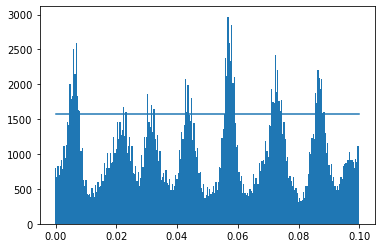

In [35]:

plt.bar(bins[:-1],Htot,width=size_window/(len(bins)-1) )
plt.plot([np.min(bins),np.max(bins)],[moyenne_plus,moyenne_plus])


In [36]:
pics_bins = np.array(list(set(delimiters)))
pics_bins_changed = np.array([pics_bins[:,0],pics_bins[:,1]]).T
times_pics = bins[:-1][pics_bins_changed]
times_pics

array([[0.0836, 0.0908],
       [0.0284, 0.0352],
       [0.0396, 0.0476],
       [0.002 , 0.01  ],
       [0.018 , 0.0264],
       [0.054 , 0.0612],
       [0.0684, 0.0764]])

In [37]:
times_pics.ravel()[1:]

array([0.0908, 0.0284, 0.0352, 0.0396, 0.0476, 0.002 , 0.01  , 0.018 ,
       0.0264, 0.054 , 0.0612, 0.0684, 0.0764])

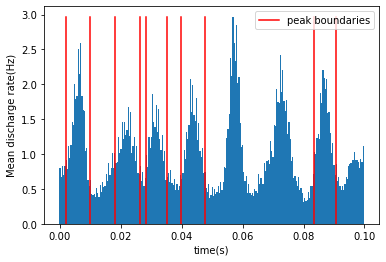

In [38]:
plt.bar(bins[:-1],Htot/(time_range*5),width=size_window/(len(bins)-1))
higher=np.max(Htot)/(time_range*5)
plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")
i = times_pics.ravel()[0]
plt.plot([i,i],[0,higher],c="red",label="peak boundaries")
for i in times_pics.ravel()[1:10]:
    plt.plot([i,i],[0,higher],c="red")
plt.legend()

In [28]:
pics_bins = np.array(list(set(delimiters)))
pics_bins_changed = np.array([pics_bins[:,0],pics_bins[:,1]]).T
times_pics = bins[:-1][pics_bins_changed]


In [29]:
pics_bins_changed

array([[79, 94],
       [62, 81],
       [26, 39],
       [50, 64],
       [37, 50],
       [-1, 12]])

In [30]:
distancesN = data_in_time[times[-1]]
scores_pics = []
for tms in times_pics:
    scores_pics.append(np.array([ np.sum(np.logical_and(np.array(x)[:,0]<tms[1],np.array(x)[:,0]>tms[0]))/len(x) if len(x)>0 else 0 for x in distancesN]))



In [1614]:
percentage_pic = []
for bins in range(len(pics_bins_changed)):
    percentage_pic.append(np.sum(Htot[pics_bins_changed[bins][0]:pics_bins_changed[bins][1]])/np.sum(Htot))

In [1615]:
Htot[pics_bins_changed[0][0]:pics_bins_changed[0][1]]

array([ 9453,  8168,  9150,  9620, 12020, 12830, 15065, 15329, 16795,
       15305, 14076, 11562,  9854])

In [1616]:
percentage_pic

[0.1157067012759006,
 0.13219792373663458,
 0.12383168401730656,
 0.12641211633237073,
 0.09417088260813326,
 0.15569213865590797,
 0.10436762331356286,
 0.09445792027764899]

In [1637]:
in_pics = []
for i in range(len(percentage_pic)):
    perc = percentage_pic[i]
    pic_ones = []
    for j in range(len(scores_pics[i])):
        score = scores_pics[i][j]
        if score > perc*2: # CHANGED
            pic_ones.append(j)
    in_pics.append(pic_ones)

In [1638]:
def take_spikes_pics(distancesN):
    spikes_in_pics = []
    for pic_ones in in_pics:
        spikes_in_pics.append(np.array([]))
        for one in pic_ones :
            train = np.array(distancesN[one])[:,0]
            spikes_in_pics[-1]=np.append(spikes_in_pics[-1],train)
    return spikes_in_pics
spikes_in_pics=take_spikes_pics(distancesN)


<BarContainer object of 100 artists>

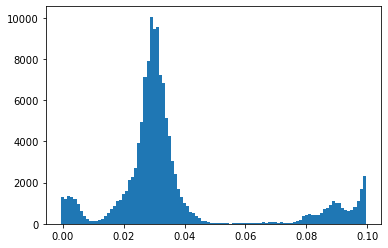

In [1639]:
which_pic=1
H, bins = np.histogram(spikes_in_pics[which_pic],bins=100);

plt.bar(bins[:-1],H,width=size_window/(len(bins)-1))


In [1640]:
np.sum([len(i) for i in in_pics])

4897

In [1641]:
len(set([j for i in in_pics for j in i]))

3650

In [1642]:
dstss =[]
for n in range(nb_neurons):
    if n in in_pics[which_pic]:
        dstss.append(len(distancesN[n][:,0]))


Text(0, 0.5, 'Mean discharge rate(Hz)')

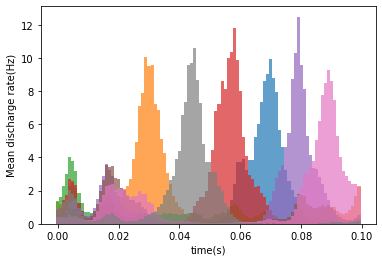

In [1643]:
somme=0
somme_hist = np.zeros(100)
for which_pic in range(len(percentage_pic)):
    H, bins = np.histogram(spikes_in_pics[which_pic],bins=100);
    somme += np.sum(H)
    somme_hist += H
    plt.bar(bins[:-1],H/(time_range*5),width=size_window/(len(bins)-1),alpha=0.7)

plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")

In [1644]:
spikes_in_pics[which_pic]

array([0.0464, 0.0487, 0.0471, ..., 0.0046, 0.0447, 0.0332])

Text(0, 0.5, 'Mean discharge rate(Hz)')

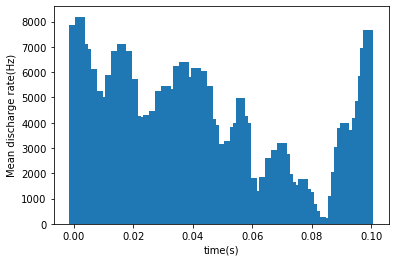

In [1646]:
plt.bar(bins[:-1],np.clip(Htot-somme_hist,0,None),width=(1/(len(bins)*3)));
plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")

<BarContainer object of 100 artists>

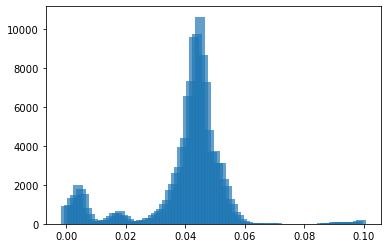

In [1647]:
plt.bar(bins[:-1],H,width=(1/(len(bins)*3)),alpha=0.7)

In [1035]:
print("Spikes represent "+str((somme/np.sum(Htot))*100)+"% of the activity")

Spikes represent 118.93901873076909% of the activity


## Load weights

In [299]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

In [300]:
wmatfilesext  = ["%s/rf1.%i.ext.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
wext = np.sum( [ mmread(wf) for wf in wmatfilesext ] )

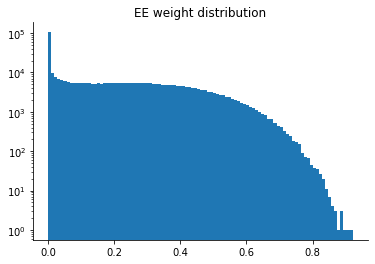

In [301]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()


In [302]:
net = Network(notebook=True)
mean_weight = np.mean(w.data)

In [303]:
def connectivity(neurones):
    connectivity_pat =[]
    bon_poids=[]
    for n in neurones:
        for n2 in neurones:
            if w[n,n2]>0:
#                 if w[n,n2]>mean_weight:
#                     bon_poids.append(w[n,n2])
                    #net.add_edge(int(n), int(n2), weight=float(w[n,n2]))
                connectivity_pat.append([n,n2,w[n,n2]])
    return np.array(connectivity_pat)
def connectivity_two(neurones1,neurones2,the_w):
    connectivity_pat =[]
    bon_poids=[]
    for n in neurones1:
        for n2 in neurones2:
            if the_w[n,n2]>0:
#                 if w[n,n2]>mean_weight:
#                     bon_poids.append(w[n,n2])
#                     #net.add_edge(int(n), int(n2), weight=float(w[n,n2]))
                connectivity_pat.append([n,n2,the_w[n,n2]])
    return np.array(connectivity_pat)    

## Neurons in time 

In [1648]:
import copy

In [1649]:
nb_bins = 30

In [1650]:
neuron_hist = [[] for n in range(nb_neurons)]
for n in range(nb_neurons):
    data = np.histogram(distancesN[n][:,0],bins=nb_bins)
    neuron_hist[n]= data[0]
    times = data[1]

In [1651]:
neuron_hist_prev = np.array(neuron_hist)

In [1652]:
sum_of_rows = neuron_hist_prev.sum(axis=1)
neuron_hist = neuron_hist_prev / sum_of_rows[:, np.newaxis]

In [1653]:
neuron_hist = list(neuron_hist)

In [1654]:
ordered_neuron_hist = []
min_activity_neuron= np.argmin(np.sum(neuron_hist_prev,axis=1) )
actual = neuron_hist[min_activity_neuron]
neuron_hist_copy = copy.deepcopy(neuron_hist)
neuron_hist_copy.pop(min_activity_neuron)
ordered_neuron_hist.append(actual)
while len(neuron_hist_copy)>0:
    next_one = np.argmin((np.sum(np.abs(neuron_hist_copy - actual),axis=1)))
    ordered_neuron_hist.append(neuron_hist_copy[next_one])
    actual = neuron_hist_copy[next_one]
    neuron_hist_copy.pop(next_one)

In [1655]:
# plt.pcolormesh(times,range(nb_neurons),ordered_neuron_hist, cmap=plt.cm.Reds)
# plt.colorbar()

In [1656]:
# plt.pcolormesh(times,range(nb_neurons),neuron_hist, cmap=plt.cm.Reds)
# plt.colorbar()

In [1657]:
# plt.pcolormesh(ordered_neuron_hist, shading = "gouraud" ,cmap=plt.cm.Reds)
# plt.colorbar()

In [1658]:
# plt.hist(distancesN[min_activity_neuron][:,0])

In [1659]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [1660]:
clustering = KMeans(len(in_pics)+1).fit_predict(neuron_hist)

In [1661]:
set(clustering)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [1686]:
dist_clust = []
all_dist_clust = np.array([])
for n in range(nb_neurons):
    if clustering[n]==7:
        dist_clust.append(distancesN[n][:,0])
        all_dist_clust = np.append(all_dist_clust,distancesN[n][:,0])

In [1687]:
len(np.where(clustering==5)[0])

262

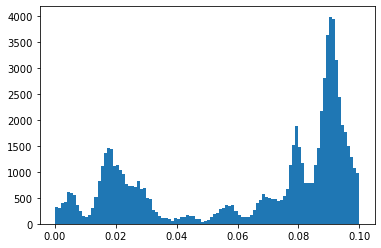

In [1688]:
plt.hist(all_dist_clust,bins=100);